This is a script written by Zach Monge to accompany my Medium blog post "Does Deep Learning Really Require 'Big Data'? -- No!" (https://medium.com/@zachmonge). To exmplify how deep learning can work quite well on small datasets, I will train a classifier to distinguish between pictures of clown fish and blue damsels. These images were downloaded from Google Image.

This script makes use of the deep learning library fastai, which is written on top of PyTorch. I would like to thank the creators of fastai for this amazing deep learning library and for their lessons. During training I used Google Cloud Platform and a K80 GPU. 

In [1]:
# Importing functions
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import glob

/home/zachm/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Examining the data

In [2]:
# Path to data
PATH = '/home/zachm/fastai_data/fish/'
os.listdir(PATH)

['train', 'valid', 'models', 'tmp']

In [3]:
# As can be seen, there are two image categories -- damsels and clown fish (titled clown)
os.listdir(f'{PATH}/train')

['damsel', 'clown']

In [4]:
# Number of training items for each category
[len(os.listdir(f'{PATH}/train/clown')),len(os.listdir(f'{PATH}/train/damsel'))]

[10, 10]

In [5]:
# Number of items in the validation set for each category. I typically include about
# 20% of the items in the validation set, but here I have 50% since this is such a 
# small dataset
[len(os.listdir(f'{PATH}/valid/clown')),len(os.listdir(f'{PATH}/valid/damsel'))]

[11, 10]

In [6]:
# Creating lists of pictures in training set 
clow_train_imgs=glob.glob(f'{PATH}train/clown/*')
damsel_train_imgs=glob.glob(f'{PATH}train/damsel/*')

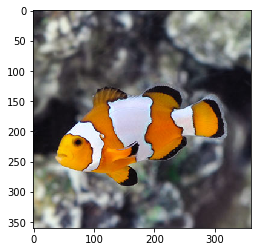

In [7]:
# Example picture of clownfish
img = plt.imread(clow_train_imgs[0])
plt.imshow(img)

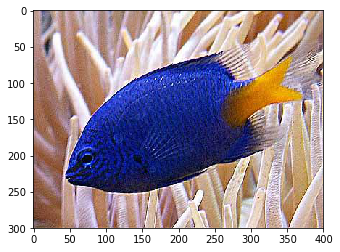

In [8]:
# Example picture of damsel
img = plt.imread(damsel_train_imgs[0])
plt.imshow(img)

# Training model

To train this model we will take advantage of a model that was pretrained on a large dataset of images. This dataset is the famous ImageNet in which the training set contains over a million of pictures. The specific model architecure I used was ResNet-34.

In [43]:
# Specifying the model architecture
arch = resnet34

# Specifying the size the images will be cropped to. I chose 224 because this is the size the model was originially trained on.
# The GPU is most efficient when all of the images are the same size
sz = 224

# Loading in the data. 
data = ImageClassifierData.from_paths(PATH,tfms=tfms_from_model(arch,sz), bs=64)

# Creating the learner from the pretrained model
learner = ConvLearner.pretrained(arch,data,precompute=True)

The next step is to fit the model, but one parameter that has traditionally been viewed as difficult to choose is the learning rate. A way to get around this is to use cyclical learning. With this approach the learning rate is varied and the change in loss is examined. We start off with a very low learning rate and gradually increase the learning rate.

If you are interested in using this technique on your own dataset, you would want to look at the plot that examines validation loss as a funciton of learning rate. You want to choose a learning rate where the loss is still decreasing but hasn't plateued yet. For visualization purposes I temporarily changed the batch size to two, but I did not actually use such a small batch size.

In [10]:
learner.lr_find()

epoch      trn_loss   val_loss   accuracy                
    0      1.242643   883.310338 0.52381   



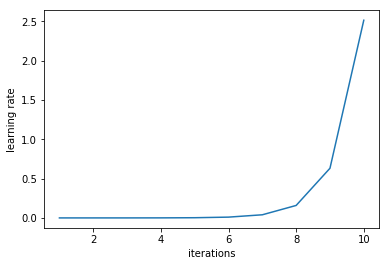

In [11]:
learner.sched.plot_lr()

As can be seen from the plot above, as the number of iterations increases, so does the learning rate. This is cyclical learning

Text(0,0.5,'validation loss')

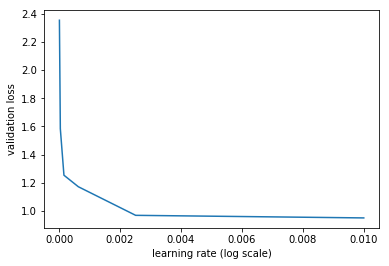

In [39]:
plt.plot(learner.sched.lrs[0:6],learner.sched.losses[0:6])
plt.xlabel('learning rate (log scale)')
plt.ylabel('validation loss')

The plot above is used to determine the learning rate. You want to choose a learning rate where the loss is still decreasing but hasn't plateued yet. This is typically more clear with larger datasets, and again this was just for visualization purposes.

Now that we have chosen our learning rate, we are ready to fit our model. Again we are training a pretrained model. The only part we are now training is the last layer, which is determining whether an image is of a clown fish or a blue damsel.

In [44]:
# Training for 2 epochs
learner.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy   
    0      0.981969   1.130187   0.47619   
    1      0.708259   0.852918   0.47619   



[array([0.85292]), 0.4761904776096344]

In [45]:
# Training for 2 epochs
learner.fit(1e-1,2)

epoch      trn_loss   val_loss   accuracy   
    0      0.384273   0.29872    0.904762  
    1      0.206507   0.090893   1.0       



[array([0.09089]), 1.0]

In [46]:
# Training for 2 epochs
learner.fit(1e-1,2)

epoch      trn_loss   val_loss   accuracy   
    0      0.003237   0.071059   1.0       
    1      0.002548   0.057351   1.0       



[array([0.05735]), 1.0]

And we have achieved 100% accuracy!

## Visualizing a couple examples 

In [52]:
# First need to get the predictions of the validation set (we don't really have a test set in this example)
log_preds = learner.predict()
log_preds[0:10]

array([[-0.09031, -2.44933],
       [-0.08845, -2.46921],
       [-0.17257, -1.84201],
       [-0.05966, -2.84881],
       [-0.48838, -0.95094],
       [-0.06853, -2.7145 ],
       [-0.22789, -1.59069],
       [-0.04632, -3.09532],
       [-0.05843, -2.86905],
       [-0.13797, -2.0489 ]], dtype=float32)

In [54]:
# This tells us that the left side is clowns and the right side are blue damsels
data.classes

['clown', 'damsel']

In [73]:
# Getting predictions
predictions=np.argmax(log_preds,axis=1)

Text(0.5,1,'clown fish')

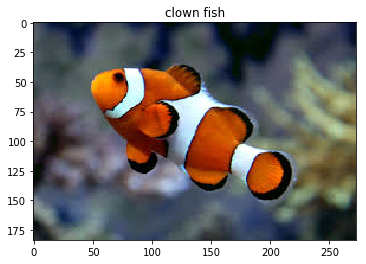

In [75]:
img = plt.imread(f'{PATH}{data.val_ds.fnames[0]}')
prediction_title = predictions[0]
if prediction_title == 0:
    prediction_title_use = 'clown fish'
else:
    prediction_title_use = 'blue damsel'
plt.imshow(img)
plt.title(prediction_title_use)

Text(0.5,1,'blue damsel')

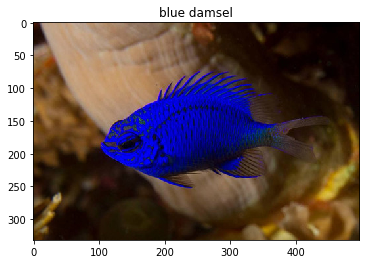

In [76]:
img = plt.imread(f'{PATH}{data.val_ds.fnames[12]}')
prediction_title = predictions[12]
if prediction_title == 0:
    prediction_title_use = 'clown fish'
else:
    prediction_title_use = 'blue damsel'
plt.imshow(img)
plt.title(prediction_title_use)

# Data augmentation

We have 100% accuracy so it may not be necessary to further improve our model, but one way we can improve the model is through data augmentation. Data augmentation slightly changes the image, so during each epoch, the image looks a little bit different. This should improve our accuracy since each epoch the model is seeing essentially a different image.

To do this, we add in aug_tfms=transforms_side_on. I am choosing transforms_side_one because the pictures are taken side on. Alterntatively, I could have chosen transforms_top_down which would be more appropriate for images taken top down, such as satellite images. I am also adding in the parameter max_zoom, which will slightly change how zoomed in the image is during each transformation. Unrelated to data augmentation, I am adding padding around the image. This is just so the convolutional filters are able to capture the whole image

In [78]:
tfms=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1,pad=1)

In [142]:
# Visualizing data augmentations
def get_augs():
    data = ImageClassifierData.from_paths(PATH,tfms=tfms, bs=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

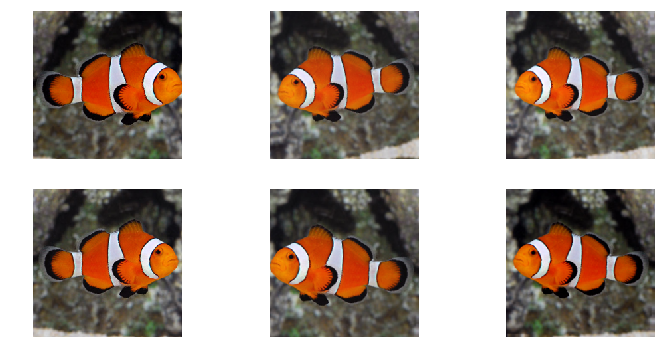

In [143]:
imgs = np.stack([get_augs() for i in range(6)])
plots(imgs,rows=2)

As can be seen, the image is slightly changed with each transformation

In [144]:
# Specifying the model architecture
arch = resnet34

# Specifying the size the images will be cropped to. I chose 224 because this is the size the model was originially trained on.
# The GPU is most efficient when all of the images are the same size
sz = 224

# Loading in the data. 
data = ImageClassifierData.from_paths(PATH,tfms=tfms, bs=64)

To use data augmentation, precompute needs to be set to False, but I typically start with precompute set to True

In [145]:
# Creating the learner from the pretrained model
learner = ConvLearner.pretrained(arch,data,precompute=True)

In [146]:
learner.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy   
    0      0.465401   0.413856   0.904762  
    1      0.507028   0.354408   0.952381  



[array([0.35441]), 0.9523809552192688]

In [148]:
# Setting precompute to False
learner.precompute=False

In [149]:
learner.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy                
    0      0.263918   0.330522   0.952381  
    1      0.46127    0.268583   0.952381  



[array([0.26858]), 0.9523809552192688]

In [150]:
learner.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy                
    0      0.425879   0.249438   0.952381  
    1      0.313408   0.219337   0.952381  



[array([0.21934]), 0.9523809552192688]

In [151]:
learner.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy                
    0      0.149426   0.210596   1.0       
    1      0.102872   0.195116   1.0       



[array([0.19512]), 1.0]

And again we are back to 100% accuracy!

# Differential learning rates

In all of the previous examples all we were doing was training the last layer and this worked fine for this example dataset, but a powerful approach is to train all of the layers but with different learning rates. Remember that our pretrained model comes from ImageNet. Previous work has determined that filters from early layers detect low-level visual features such as edges and as we go deeper and deeper into the network, the filters start to pick up on higher-order visual features. So how much we train each layer is going to depend on how similar our dataset is to ImageNet. In this example, we are training pictures of fish, which are also contained witin ImageNet, so we are not going to want to change the early layers as much (or maybe even at all!) as the later layers.

In [152]:
# Reloading the dataset and model

# Specifying the model architecture
arch = resnet34

# Specifying the size the images will be cropped to. I chose 224 because this is the size the model was originially trained on.
# The GPU is most efficient when all of the images are the same size
sz = 224

# Loading in the data. 
data = ImageClassifierData.from_paths(PATH,tfms=tfms, bs=64)

# Creating the learner from the pretrained model
learner = ConvLearner.pretrained(arch,data,precompute=False)

In [153]:
# Setting all of the layers to trainable
learner.unfreeze()

Below we are setting the learning rates for the first, middle, and last layers (going from left to right). As you can see, the lowest learning rate is for the first layers which we don't want to change that much and the highest for the last layers which we want to change the most.

In [154]:
lr = np.array([1e-4,1e-3,1e-2])

In [155]:
learner.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                
    0      0.792518   0.524254   0.761905  
    1      0.750036   0.386865   0.904762  



[array([0.38687]), 0.9047619104385376]

In [156]:
learner.fit(lr,2)

epoch      trn_loss   val_loss   accuracy               
    0      0.619916   0.341252   0.904762  
    1      0.47245    0.277228   0.952381  



[array([0.27723]), 0.9523809552192688]

In [157]:
learner.fit(lr,2)

epoch      trn_loss   val_loss   accuracy               
    0      0.239755   0.261985   0.952381  
    1      0.337867   0.219976   1.0       



[array([0.21998]), 1.0]

In [158]:
learner.fit(lr,2)

epoch      trn_loss   val_loss   accuracy               
    0      0.279706   0.206491   1.0       
    1      0.203719   0.185515   1.0       



[array([0.18552]), 1.0]

In [159]:
learner.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                 
    0      0.077945   0.18009    1.0       
    1      0.137642   0.164483   1.0       



[array([0.16448]), 1.0]

We again get 100% accuracy!

# Stochastic Gradient Descent with Restarts

My next tip is to use something called stocahstic gradient descent with restarts (SGDR). This is a variant of learning rate annealing, in which the learning rate is gradually decreased as training progresses. The theory is that as we get closer to the minimum, we need to start using smaller learning rates so we don't miss the minimum. The problem is that we could get stuck in a minimum that is not very resilient and does not generalize well. So what we can do is jump back up to a higher learning rate, start decreasing it again, and repeat this as much as you like.

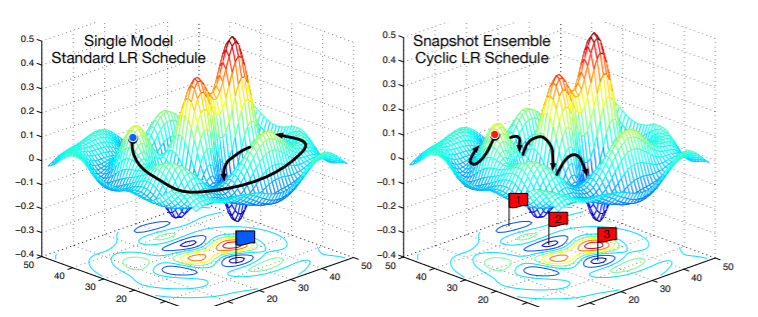

Image source: https://arxiv.org/abs/1704.00109

In [167]:
# Reloading the dataset and model

# Specifying the model architecture
arch = resnet34

# Specifying the size the images will be cropped to. I chose 224 because this is the size the model was originially trained on.
# The GPU is most efficient when all of the images are the same size
sz = 224

# Loading in the data. I am decreasing the batch size to two for visualization purposes
data = ImageClassifierData.from_paths(PATH,tfms=tfms, bs=2)

# Creating the learner from the pretrained model
learner = ConvLearner.pretrained(arch,data,precompute=False)

To do this, we add the `cycle_len` parameter

In [168]:
learner.fit(lr,3,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      0.62515    0.397631   0.857143  
    1      0.527795   0.15168    1.0                       
    2      0.520511   0.172392   0.952381                 



[array([0.17239]), 0.9523809523809523]

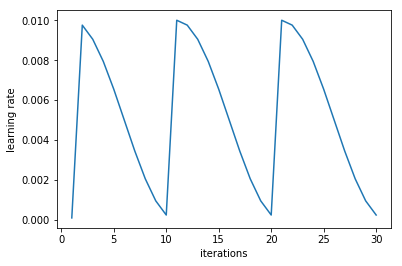

In [165]:
learner.sched.plot_lr()

As we can see, the learning rate starts off high, is gradually decreased, and then restarted.

One last trick is to add the `cycle_mult` parameter. After a cycle from highest to lowest learning rate, the span of the next cycle is multiplied by whatever you want to mulitply it by. Below I set cycle_mult to two, so this doubles the span.

In [182]:
# Reloading the dataset and model

# Specifying the model architecture
arch = resnet34

# Specifying the size the images will be cropped to. I chose 224 because this is the size the model was originially trained on.
# The GPU is most efficient when all of the images are the same size
sz = 224

# Loading in the data. I am decreasing the batch size to two for visualization purposes
data = ImageClassifierData.from_paths(PATH,tfms=tfms, bs=2)

# Creating the learner from the pretrained model
learner = ConvLearner.pretrained(arch,data,precompute=False)

In [183]:
learner.fit(lr,3,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      0.65912    0.33342    0.904762  
    1      0.772053   0.194462   0.904762                  
    2      0.856982   0.043334   1.0                      
    3      0.869054   0.177462   0.904762                 
    4      1.280438   1.257219   0.809524                 
    5      1.150399   0.028755   1.0                     
    6      1.01785    0.084579   1.0                     



[array([0.08458]), 1.0]

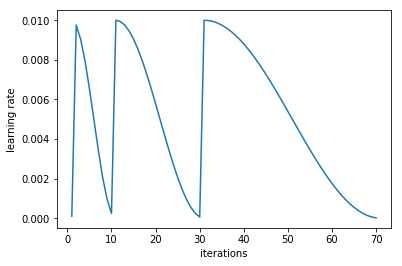

In [184]:
learner.sched.plot_lr()